In [1]:
!pip install folktables

You should consider upgrading via the '/home/denys_herasymuk/UCU/Studying_abroad/NYU_Internship/Code/RAI-summer-stability/RAI_venv/bin/python -m pip install --upgrade pip' command.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import sklearn
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from utils.model_tuning_utils import test_ML_models

/home/denys_herasymuk/UCU/Studying_abroad/NYU_Internship/Code/RAI-summer-stability/RAI_venv/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/denys_herasymuk/UCU/Studying_abroad/NYU_Internship/Code/RAI-summer-stability/RAI_venv/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [4]:
%matplotlib inline

def set_default_plot_properties():
    plt.style.use('mpl20')
    matplotlib.rcParams['figure.dpi'] = 100
    matplotlib.rcParams['figure.figsize'] = 15, 5

def sns_set_size(height, width):
    sns.set(rc={'figure.figsize':(width, height)})

set_default_plot_properties()

import warnings
warnings.filterwarnings('ignore')

### Python & Library Versions

In [5]:
versions = ( ("matplotlib", matplotlib.__version__),
             ("numpy", np.__version__),
             ("pandas", pd.__version__),
             ("sklearn", sklearn.__version__),
             ("seaborn", sns.__version__)
             )

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))


3.8.10 (default, Mar 15 2022, 12:22:08) 
[GCC 9.4.0] 

library    version
------------------
matplotlib  3.5.2
numpy       1.21.2
pandas      1.3.3
sklearn     1.1.1
seaborn     0.11.2


### Read a dataset

In [6]:
from folktables import ACSDataSource, ACSEmployment

data_source = ACSDataSource(survey_year='2016', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["FL"], download=True)
features, label, group = ACSEmployment.df_to_numpy(acs_data)

### Data Pre-processing

In [7]:
ACSEmployment.target

'ESR'

In [8]:
ACSEmployment.features

['AGEP',
 'SCHL',
 'MAR',
 'RELP',
 'DIS',
 'ESP',
 'CIT',
 'MIG',
 'MIL',
 'ANC',
 'NATIVITY',
 'DEAR',
 'DEYE',
 'DREM',
 'SEX',
 'RAC1P']

In [9]:
features.shape, acs_data.shape

((196828, 16), (196828, 284))

In [10]:
# Create pandas datafrane with features and label column
full_df = acs_data[ACSEmployment.features + [ACSEmployment.target]].copy()
full_df.head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,54,16.0,1,0,2,NaN,4,1.0,4.0,1,2,2,2,2.0,1,1,1.0
1,50,16.0,1,1,2,NaN,4,1.0,4.0,1,2,2,2,2.0,2,1,3.0
2,24,21.0,5,2,1,NaN,4,1.0,4.0,1,2,1,2,1.0,1,1,1.0
3,36,19.0,5,0,2,NaN,1,1.0,4.0,1,1,2,2,2.0,2,1,1.0
4,19,19.0,5,2,1,NaN,1,1.0,4.0,1,1,1,2,2.0,2,8,6.0


In [11]:
# Convert label column to binary format
full_df['LABEL_ESR'] = ACSEmployment.target_transform(full_df[ACSEmployment.target])
full_df.drop([ACSEmployment.target], axis=1, inplace=True)

In [12]:
full_df['AGEP'].describe()

count    196828.000000
mean         44.721285
std          23.990470
min           0.000000
25%          24.000000
50%          47.000000
75%          64.000000
max          95.000000
Name: AGEP, dtype: float64

In [13]:
full_df.isnull().sum()

AGEP              0
SCHL           5043
MAR               0
RELP              0
DIS               0
ESP          164359
CIT               0
MIG            1624
MIL           32393
ANC               0
NATIVITY          0
DEAR              0
DEYE              0
DREM           8369
SEX               0
RAC1P             0
LABEL_ESR         0
dtype: int64

### Checking If Nulls Mean a Separate Category

In [14]:
full_df.isnull().sum()

AGEP              0
SCHL           5043
MAR               0
RELP              0
DIS               0
ESP          164359
CIT               0
MIG            1624
MIL           32393
ANC               0
NATIVITY          0
DEAR              0
DEYE              0
DREM           8369
SEX               0
RAC1P             0
LABEL_ESR         0
dtype: int64

In [15]:
# Percentage of nulls in each column
full_df.isnull().sum() / full_df.shape[0]

AGEP         0.000000
SCHL         0.025621
MAR          0.000000
RELP         0.000000
DIS          0.000000
ESP          0.835039
CIT          0.000000
MIG          0.008251
MIL          0.164575
ANC          0.000000
NATIVITY     0.000000
DEAR         0.000000
DEYE         0.000000
DREM         0.042519
SEX          0.000000
RAC1P        0.000000
LABEL_ESR    0.000000
dtype: float64

#### SCHL Nulls Analysis

**Hypothesis:** N/A (less than 3 years old)

In [16]:
full_df['AGEP'].value_counts()

69    3196
55    3184
54    3113
58    3088
59    3074
      ... 
87     765
88     725
89     628
90     452
91     409
Name: AGEP, Length: 93, dtype: int64

In [17]:
full_df['AGEP'][full_df['AGEP'] < 3].count()

5043

In [18]:
full_df['SCHL'].isnull().sum()

5043

#### ESP Nulls Analysis

**Hypothesis:** N/A (not own child of householder, and not child in subfamily).

In [19]:
full_df['ESP'].isnull().sum()

164359

In [20]:
full_df['ESP'].notnull().sum()

32469

Can not prove that hypothesis, since I do not have enough data for that.

In [21]:
full_df[full_df['ESP'].isnull()]['RELP'].value_counts()

0     82058
1     39675
2     13495
16     4954
13     4889
17     3247
6      2509
12     2404
15     2070
10     1986
7      1775
5      1739
11      866
4       820
9       689
8       666
3       410
14      107
Name: RELP, dtype: int64

In [22]:
full_df[full_df['ESP'].isnull()]['AGEP'].value_counts()

69    3196
55    3184
54    3113
58    3088
59    3074
      ... 
4       81
5       78
1       72
0       67
2       66
Name: AGEP, Length: 93, dtype: int64

#### MIG Nulls Analysis

**Hypothesis:** N/A (less than 1 year old).

In [23]:
full_df['MIG'].isnull().sum()

1624

In [24]:
full_df['AGEP'][full_df['AGEP'] < 1].count()

1624

#### MIL Nulls Analysis

**Hypothesis:** N/A (less than 17 years old).

In [25]:
full_df['MIL'].isnull().sum()

32393

In [26]:
full_df['AGEP'][full_df['AGEP'] < 17].count()

32393

#### DREM Nulls Analysis

**Hypothesis:** N/A (less than 5 years old).

In [27]:
full_df['DREM'].isnull().sum()

8369

In [28]:
full_df['AGEP'][full_df['AGEP'] < 5].count()

8369

**Conclusion:** all hypotheses are proved, except ESP column -- all other columns, which contain nulls, can be encoded with an extra category.

Encode nulls for a separate category

In [29]:
full_df.fillna(0, inplace = True)
full_df.isnull().sum()

AGEP         0
SCHL         0
MAR          0
RELP         0
DIS          0
ESP          0
CIT          0
MIG          0
MIL          0
ANC          0
NATIVITY     0
DEAR         0
DEYE         0
DREM         0
SEX          0
RAC1P        0
LABEL_ESR    0
dtype: int64

### Data Profiling

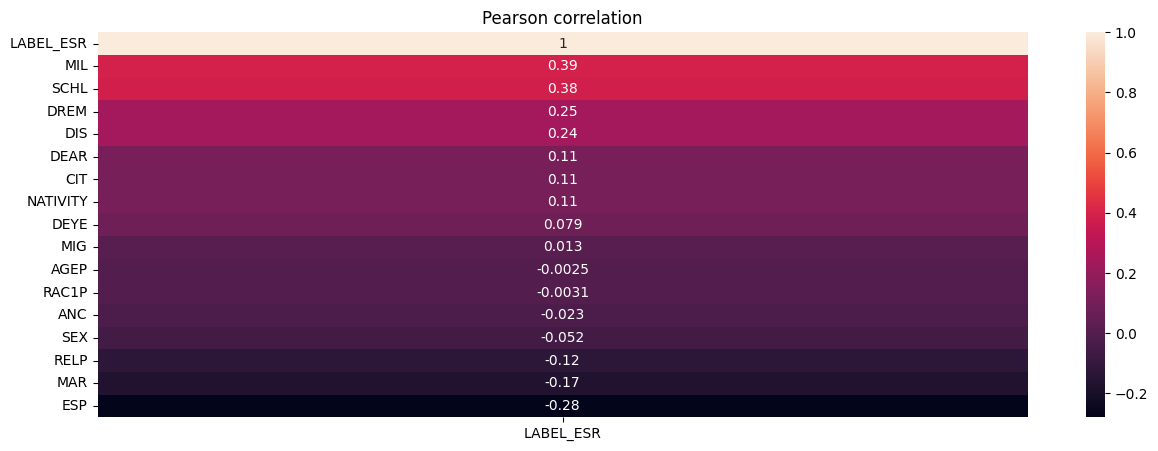

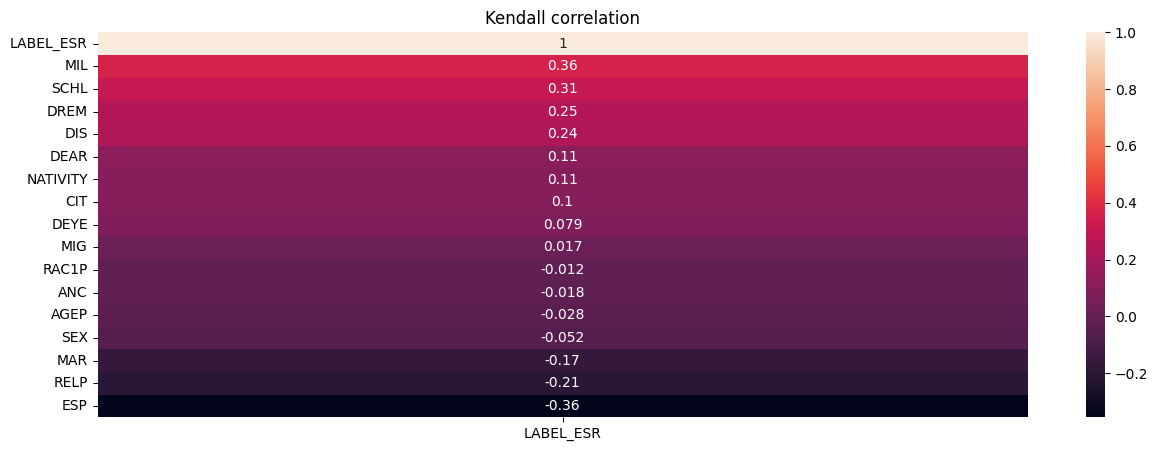

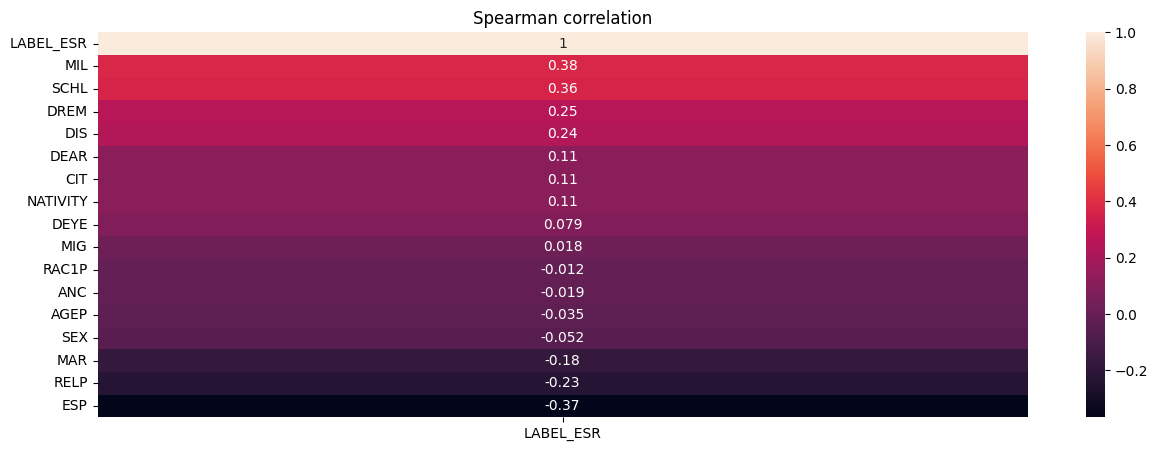

In [30]:
# Look at the feature correlation with 'LABEL_ESR' column
for method in ['pearson', 'kendall', 'spearman']:
    ax = plt.axes()
    sns.heatmap(
        full_df.corr(method=method)[['LABEL_ESR']]\
            .sort_values(by='LABEL_ESR', ascending=False),
        ax=ax,
        annot=True
    )
    ax.set_title(f'{method.capitalize()} correlation')
    plt.show()


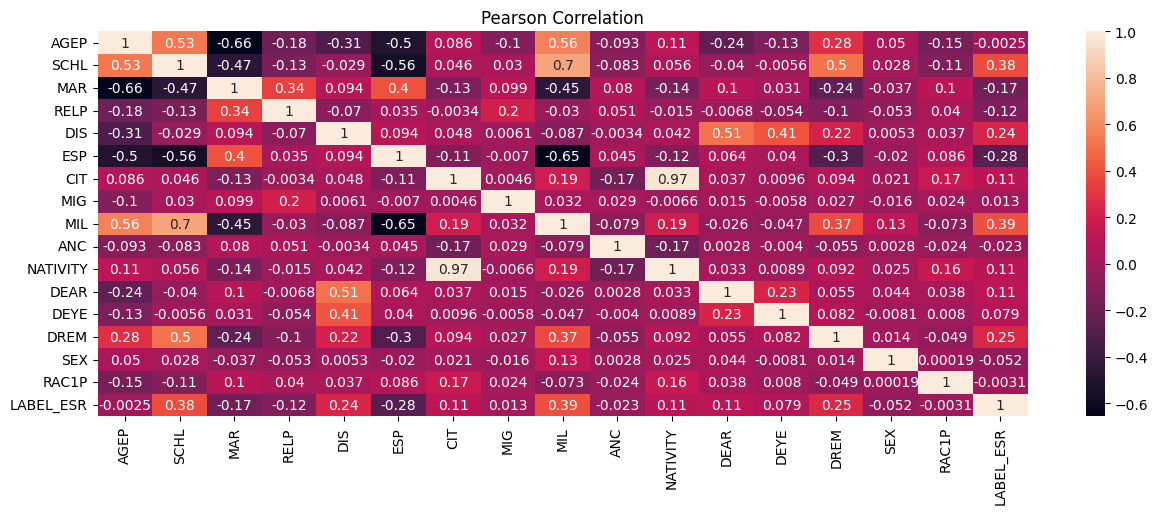

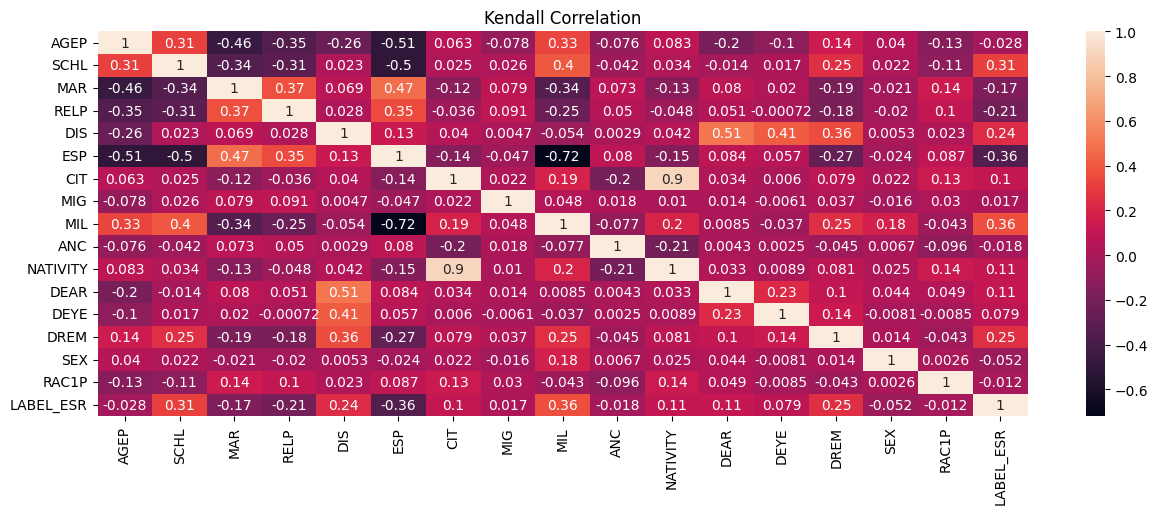

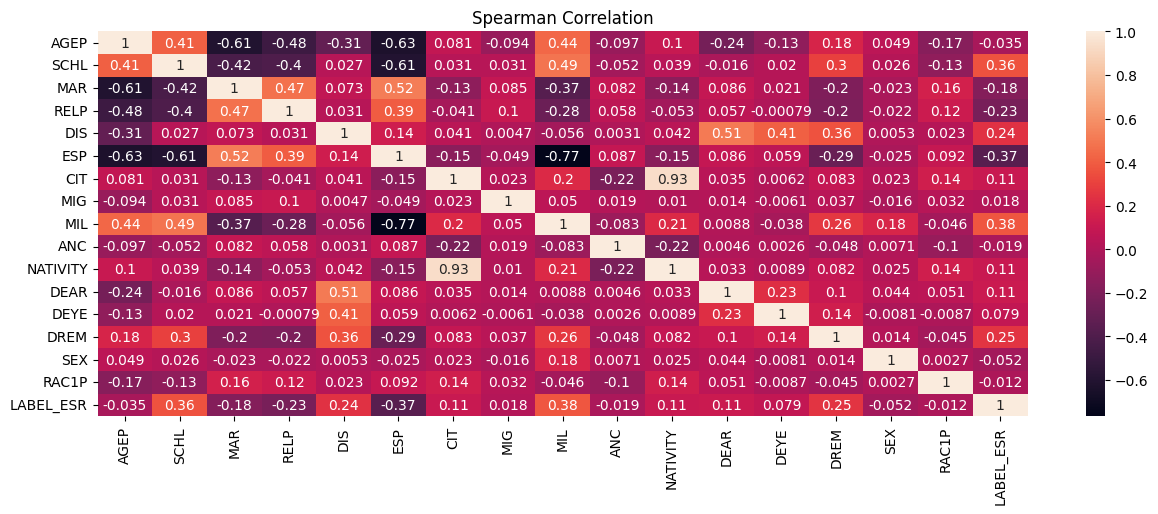

In [31]:
# Look at correlations among features
for method in ['pearson', 'kendall', 'spearman']:
    ax = plt.axes()
    sns.heatmap(full_df.corr(method=method), ax=ax, annot=True)
    ax.set_title(f'{method.capitalize()} Correlation')
    plt.show()


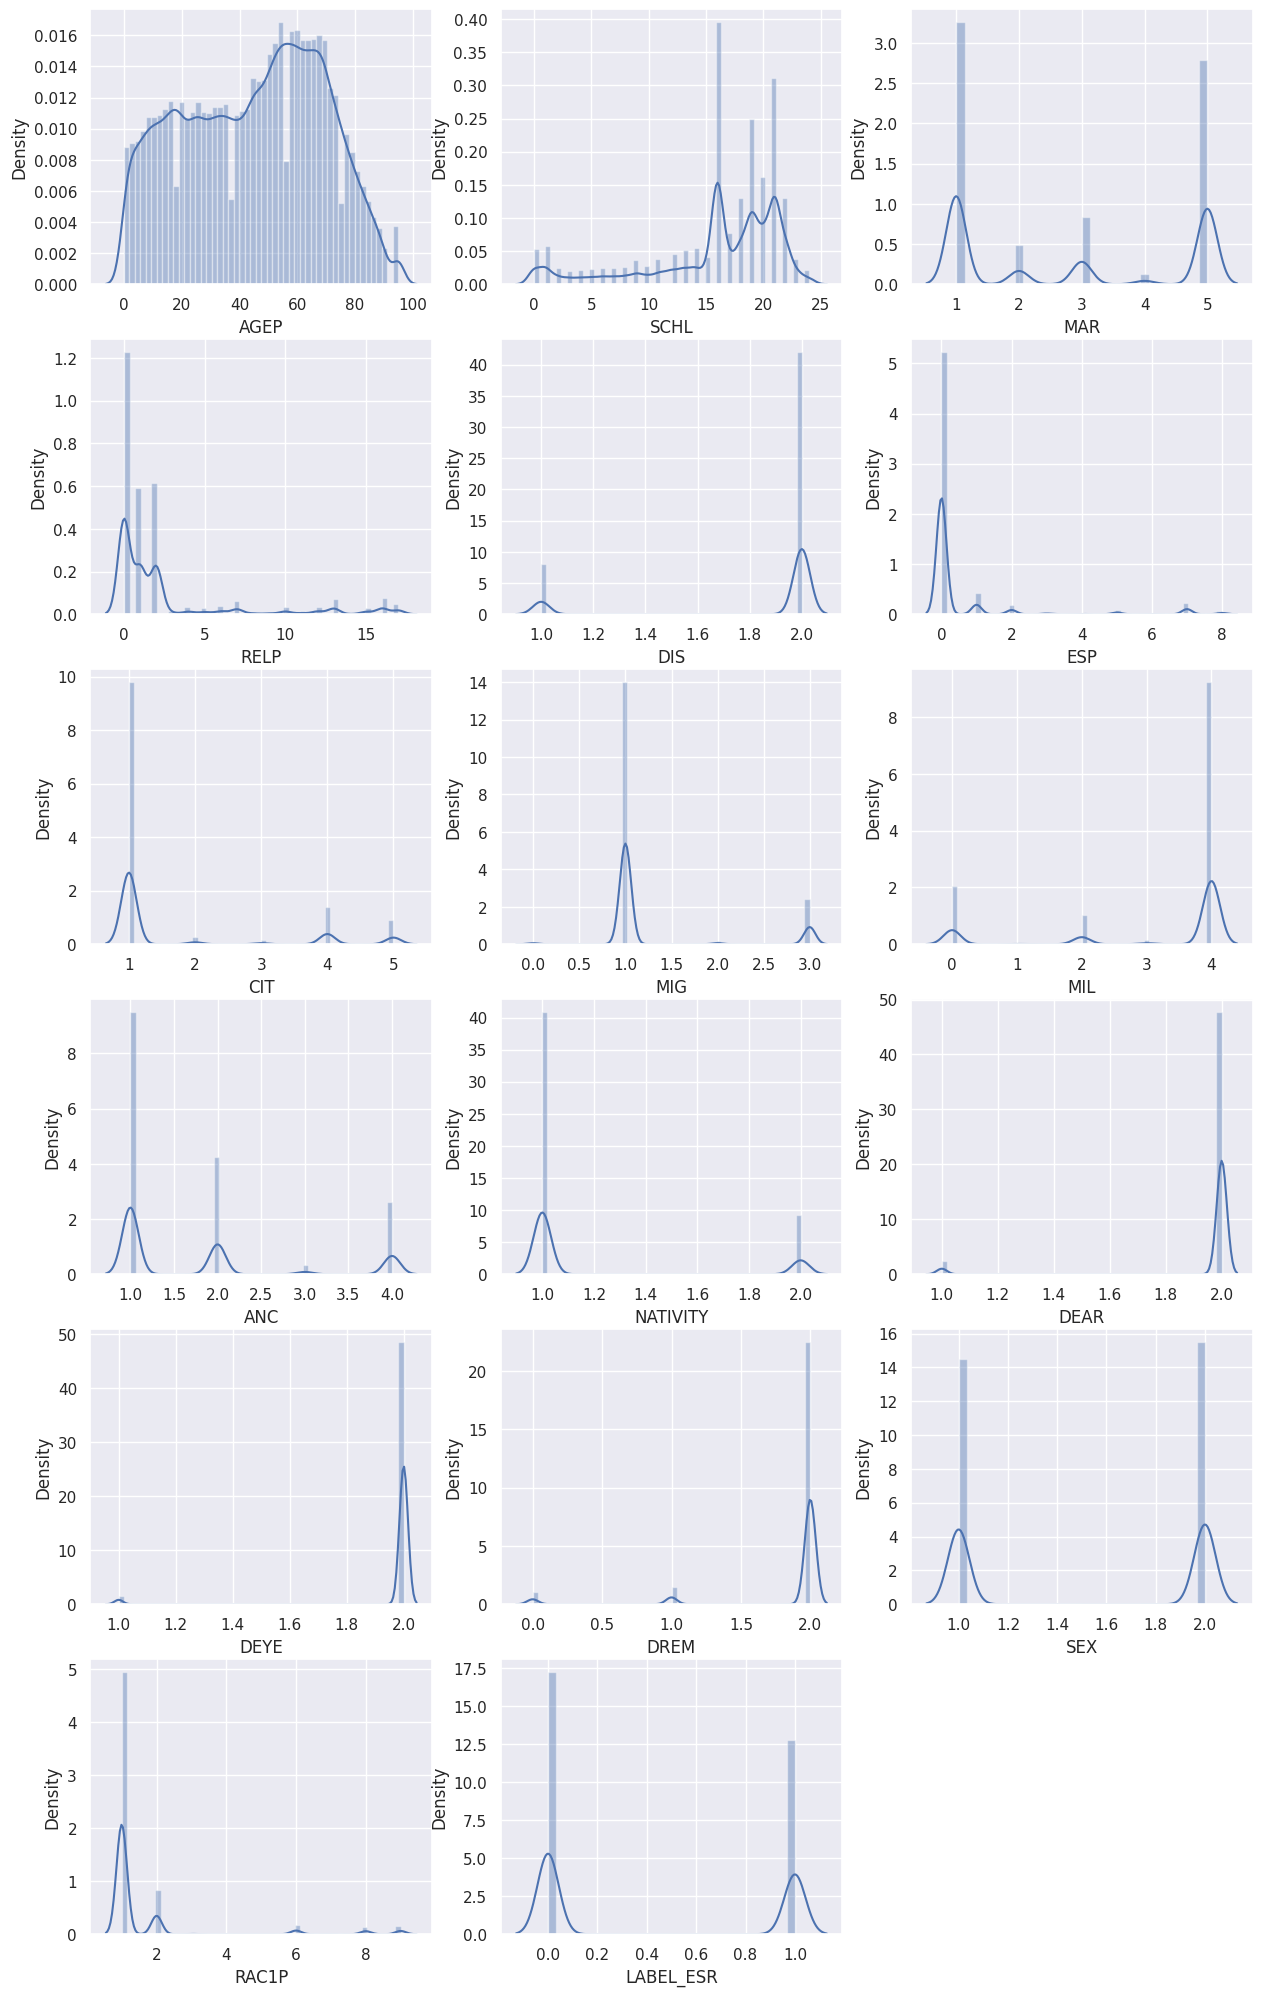

In [32]:
# Look at densities of each column
sns_set_size(height=25, width=15)

fig = plt.figure()
gs0 = matplotlib.gridspec.GridSpec(ncols=3, nrows=6, figure=fig)
for idx, column in enumerate(full_df.columns):
    n_row, n_col = divmod(idx, 3)
    ax = fig.add_subplot(gs0[n_row, n_col])
    sns.distplot(full_df[column], ax=ax)

set_default_plot_properties()

### Group Data By Race

In [33]:
def plot_column_grouped_by_race(plot_column):
    sns_set_size(height=18, width=15)

    fig = plt.figure()
    gs0 = matplotlib.gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    race_names = ['White alone', 'Black or African American alone', 'American Indian alone',
                  'Alaska Native alone', 'American Indian', 'Asian alone',
                  'Hawaiian and Other Pacific Islander alone', 'Some Other Race alone', 'Two or More Races']

    for i in range(len(race_names)):
        n_row, n_col = divmod(i, 3)
        ax = fig.add_subplot(gs0[n_row, n_col])
        ax.set_title(race_names[i])
        sns.distplot(full_df[full_df['RAC1P'] == i + 1][plot_column], ax=ax)

    set_default_plot_properties()


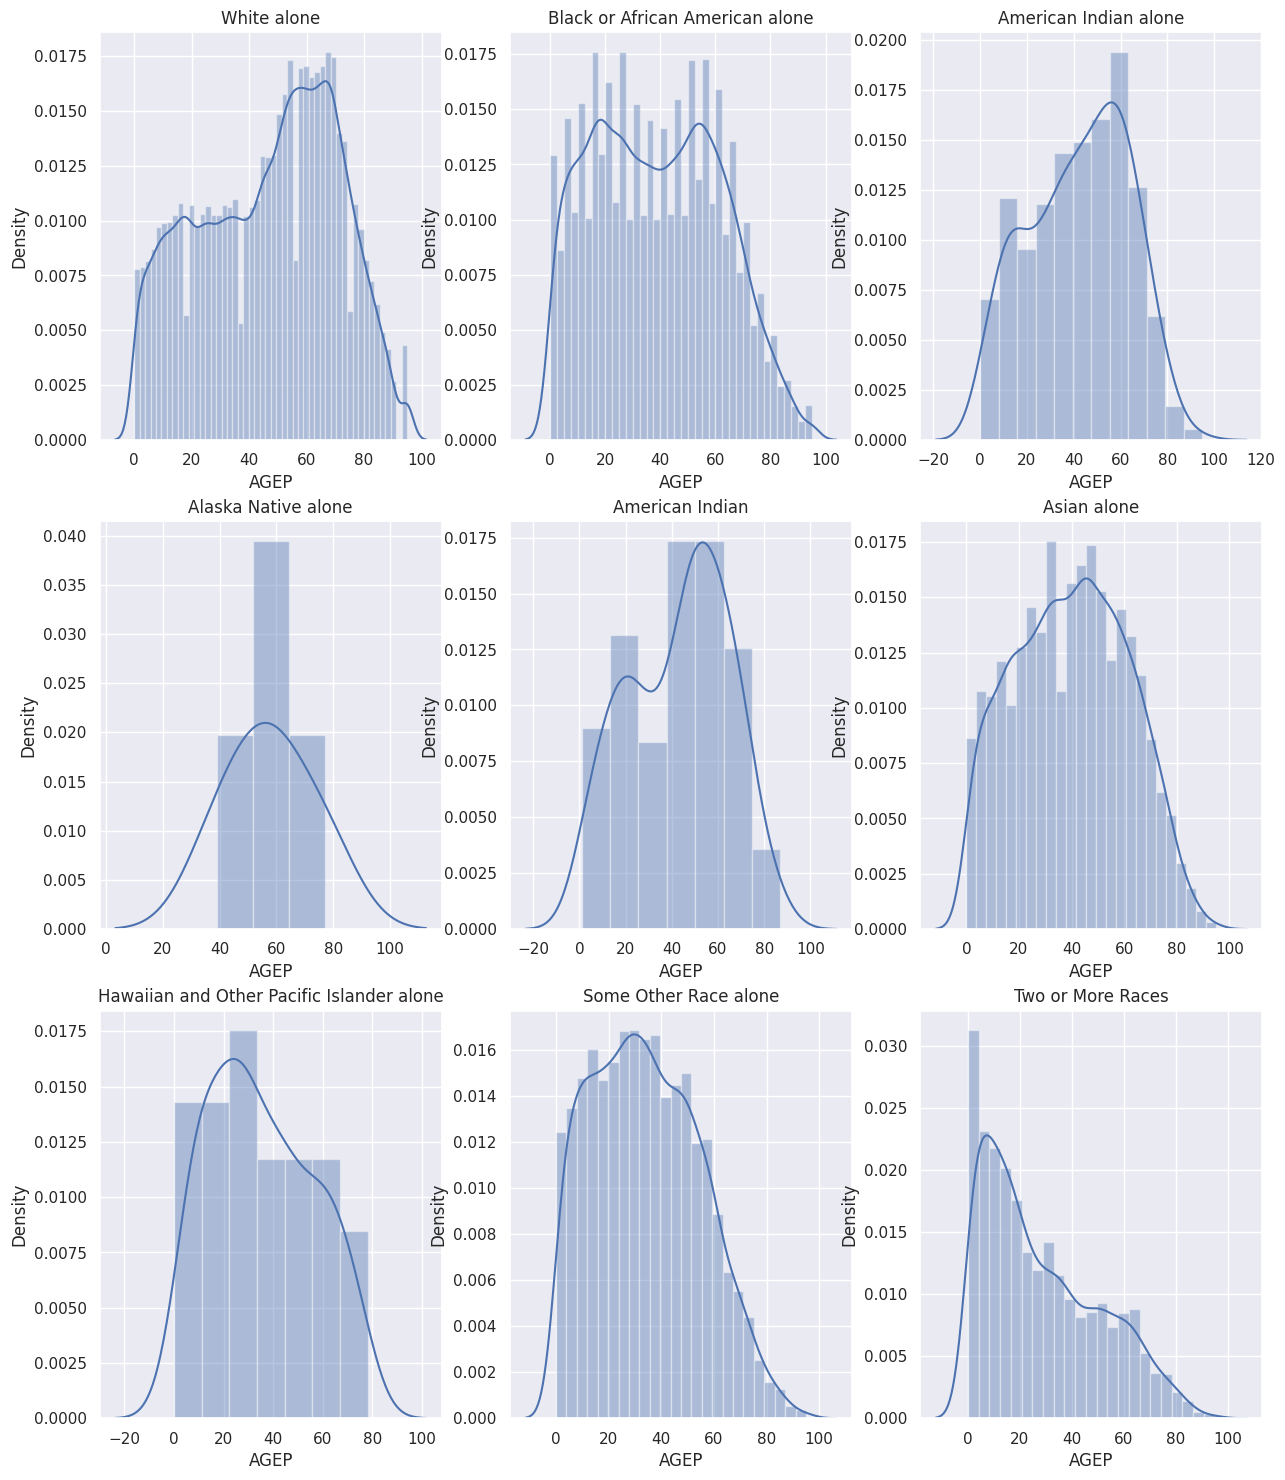

In [34]:
plot_column_grouped_by_race(plot_column='AGEP')

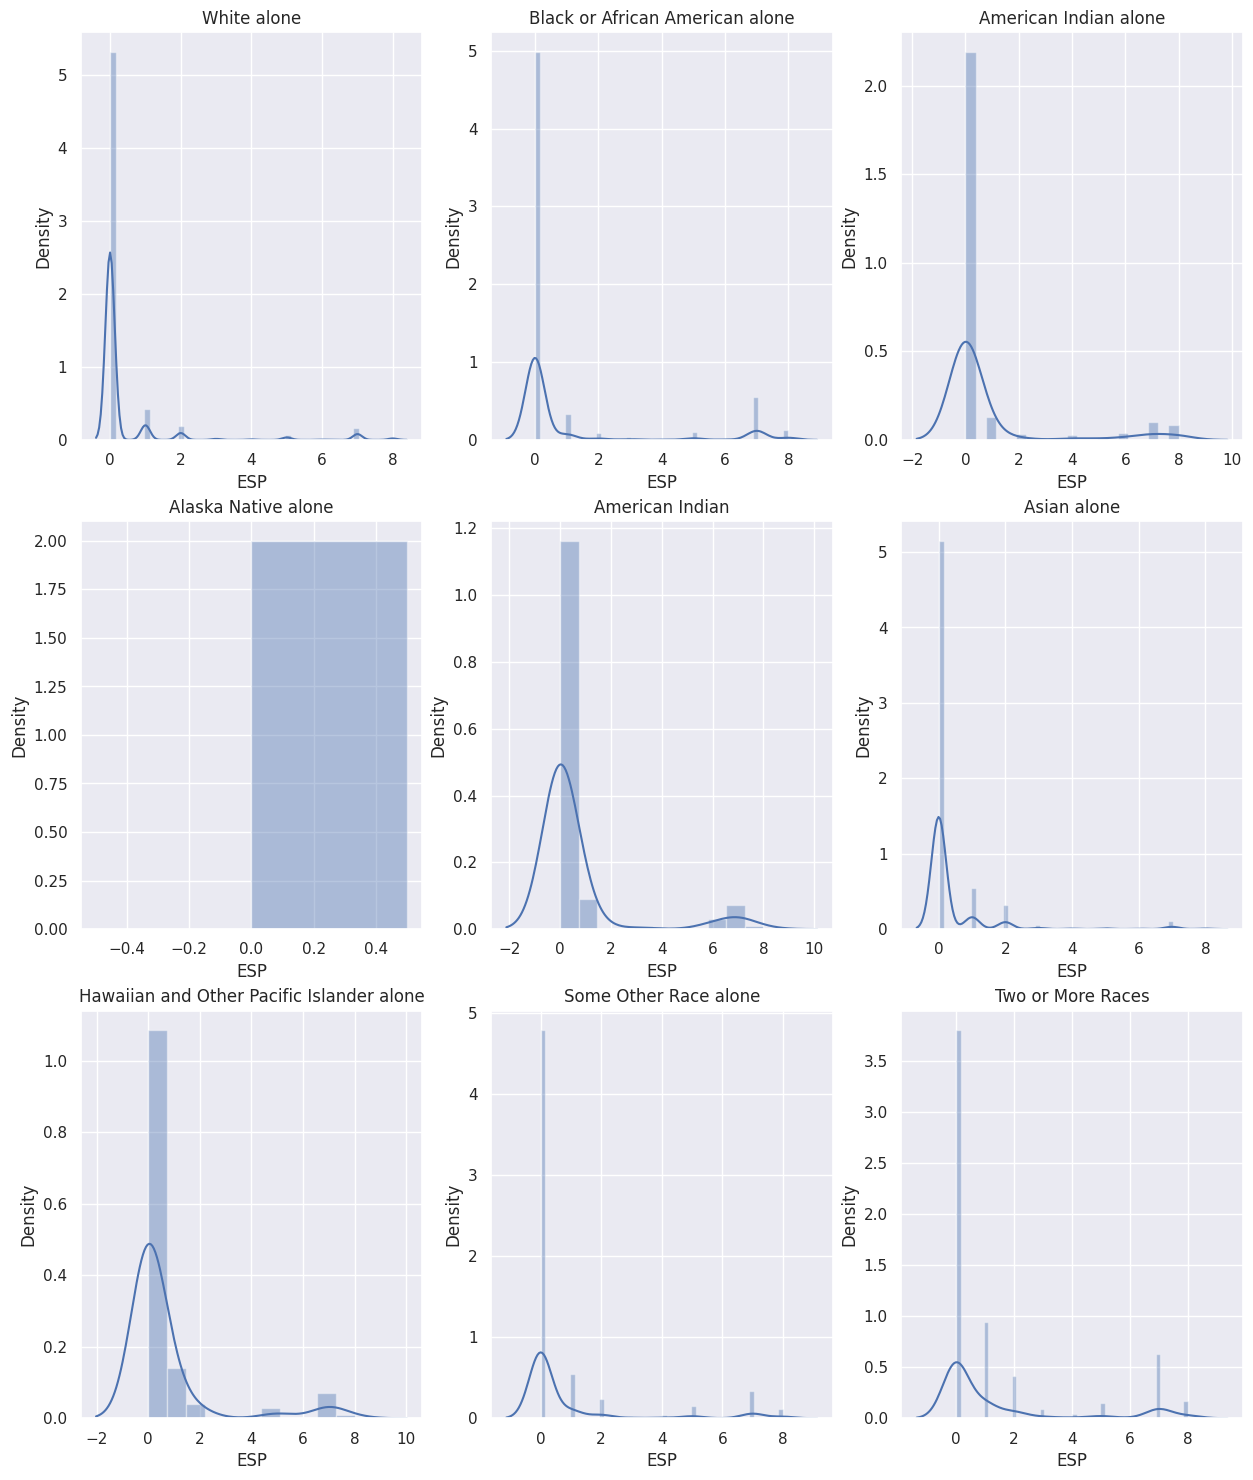

In [35]:
plot_column_grouped_by_race(plot_column='ESP')

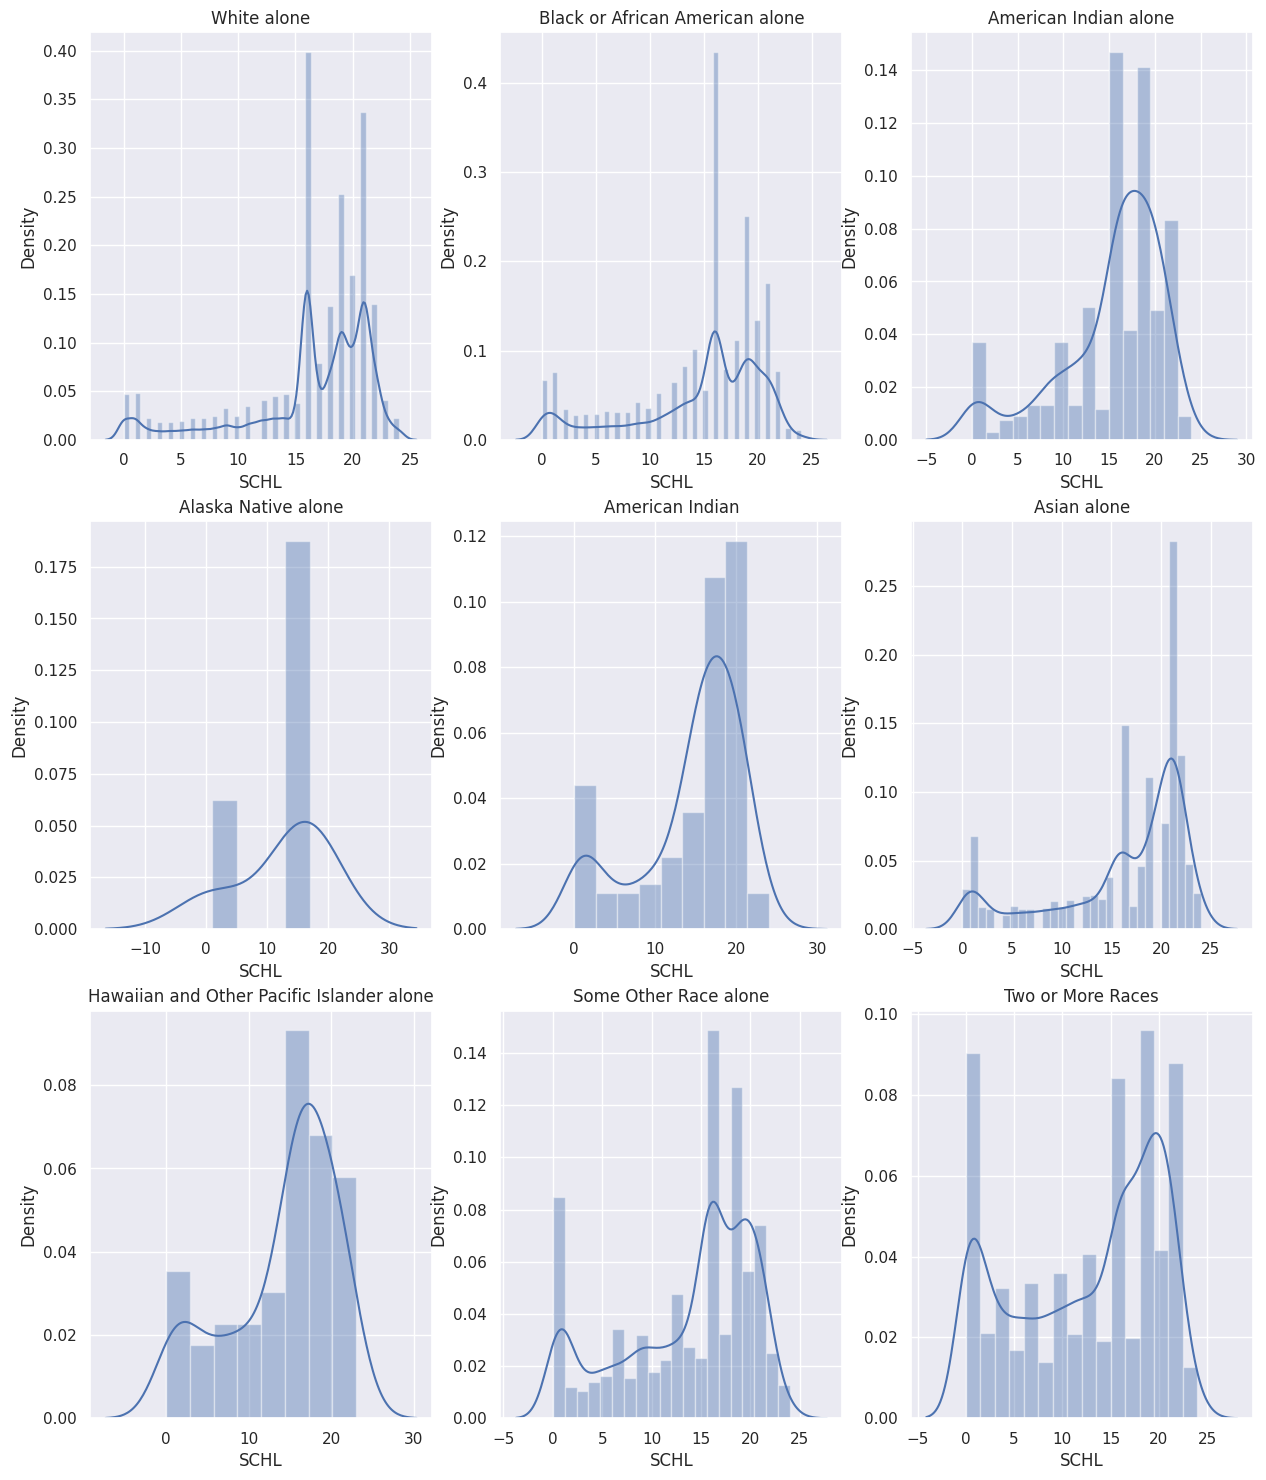

In [36]:
plot_column_grouped_by_race(plot_column='SCHL')

### Analyze Feature Importance

In [37]:
SEED = 42
features_df = full_df.drop('LABEL_ESR', axis=1, inplace=False)
target_df = full_df['LABEL_ESR']
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(features_df, target_df, test_size=0.2, random_state=SEED)
X_train_full.shape, X_test_full.shape

((157462, 16), (39366, 16))

Text(0.5, 0, 'Random Forest Feature Importance')

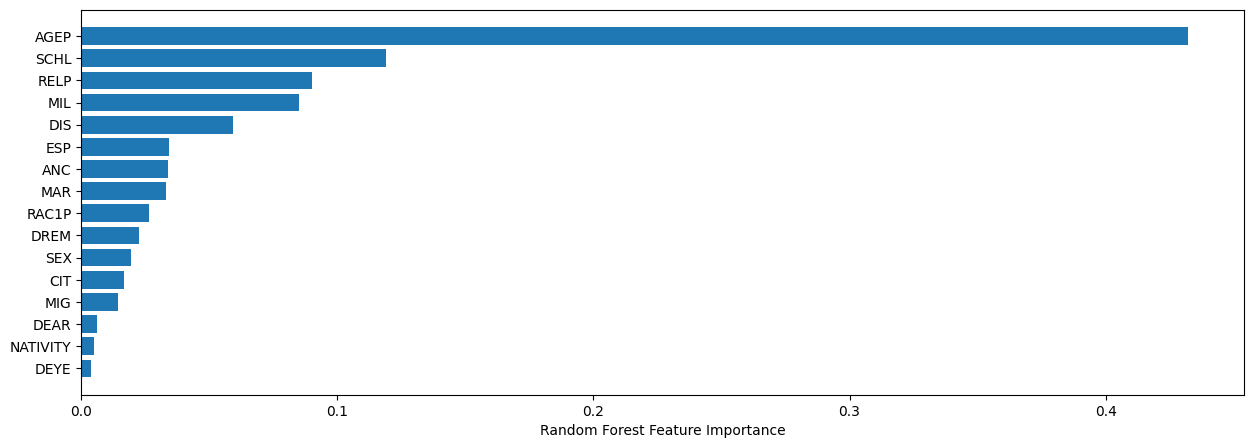

In [38]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_full, y_train_full)

sorted_idx = rf.feature_importances_.argsort()
plt.barh(features_df.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Correlation Analysis after One-Hot Encoding

In [39]:
feature_analysis_cols = [col for col in full_df.columns if col not in ['AGEP', 'SCHL']]
features_analysis_df = pd.get_dummies(full_df[feature_analysis_cols], columns=feature_analysis_cols)
features_analysis_df['AGEP'] = full_df['AGEP']
features_analysis_df['SCHL'] = full_df['SCHL']
features_analysis_df['LABEL_ESR'] = full_df['LABEL_ESR']
features_analysis_df.head()

,MAR_1,MAR_2,MAR_3,MAR_4,MAR_5,RELP_0,RELP_1,RELP_2,RELP_3,RELP_4,...,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,LABEL_ESR_False,LABEL_ESR_True,AGEP,SCHL,LABEL_ESR
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,54,16.0,True
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,50,16.0,False
2,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,24,21.0,True
3,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,36,19.0,True
4,0,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,1,0,19,19.0,False


In [40]:
features_analysis_df.columns

Index(['MAR_1', 'MAR_2', 'MAR_3', 'MAR_4', 'MAR_5', 'RELP_0', 'RELP_1',
       'RELP_2', 'RELP_3', 'RELP_4', 'RELP_5', 'RELP_6', 'RELP_7', 'RELP_8',
       'RELP_9', 'RELP_10', 'RELP_11', 'RELP_12', 'RELP_13', 'RELP_14',
       'RELP_15', 'RELP_16', 'RELP_17', 'DIS_1', 'DIS_2', 'ESP_0.0', 'ESP_1.0',
       'ESP_2.0', 'ESP_3.0', 'ESP_4.0', 'ESP_5.0', 'ESP_6.0', 'ESP_7.0',
       'ESP_8.0', 'CIT_1', 'CIT_2', 'CIT_3', 'CIT_4', 'CIT_5', 'MIG_0.0',
       'MIG_1.0', 'MIG_2.0', 'MIG_3.0', 'MIL_0.0', 'MIL_1.0', 'MIL_2.0',
       'MIL_3.0', 'MIL_4.0', 'ANC_1', 'ANC_2', 'ANC_3', 'ANC_4', 'NATIVITY_1',
       'NATIVITY_2', 'DEAR_1', 'DEAR_2', 'DEYE_1', 'DEYE_2', 'DREM_0.0',
       'DREM_1.0', 'DREM_2.0', 'SEX_1', 'SEX_2', 'RAC1P_1', 'RAC1P_2',
       'RAC1P_3', 'RAC1P_4', 'RAC1P_5', 'RAC1P_6', 'RAC1P_7', 'RAC1P_8',
       'RAC1P_9', 'LABEL_ESR_False', 'LABEL_ESR_True', 'AGEP', 'SCHL',
       'LABEL_ESR'],
      dtype='object')

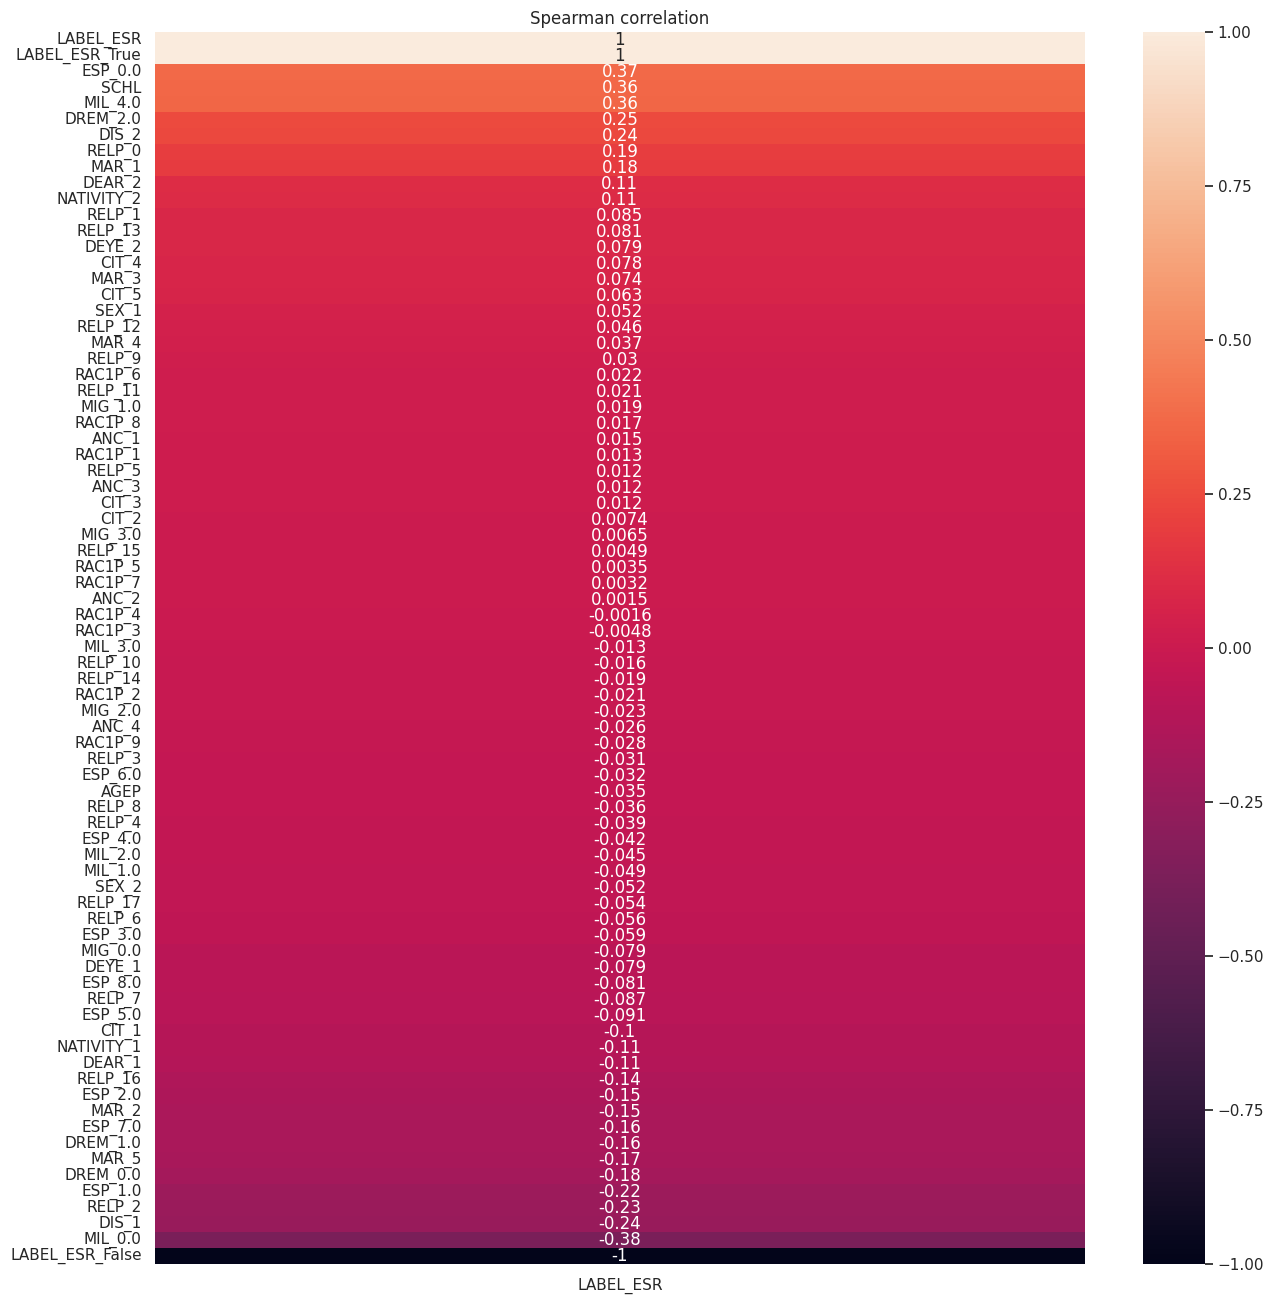

In [41]:
# Look at the feature correlation with 'LABEL_ESR' column
sns_set_size(height=16, width=15)
for method in ['spearman']:
    ax = plt.axes()
    sns.heatmap(
        features_analysis_df.corr(method=method)[['LABEL_ESR']]
            .sort_values(by='LABEL_ESR', ascending=False),
        ax=ax,
        annot=True
    )
    ax.set_title(f'{method.capitalize()} correlation')
    plt.show()

set_default_plot_properties()

### Train a baseline model

In [20]:
# Create a feature dataframe based on the feature correlation with 'LABEL_ESR' and feature importance
feature_cols = ['MIL', 'DIS', 'ESP', 'MAR', 'RELP', 'ANC']
features_df = pd.get_dummies(full_df[feature_cols], columns=feature_cols)
features_df['AGEP'] = full_df['AGEP']
features_df['SCHL'] = full_df['SCHL']
target_df = full_df['LABEL_ESR']
features_df.head()

,MIL_0.0,MIL_1.0,MIL_2.0,MIL_3.0,MIL_4.0,DIS_1,DIS_2,ESP_0.0,ESP_1.0,ESP_2.0,...,RELP_14,RELP_15,RELP_16,RELP_17,ANC_1,ANC_2,ANC_3,ANC_4,AGEP,SCHL
0,0,0,0,0,1,0,1,1,0,0,...,0,0,0,0,1,0,0,0,54,16.0
1,0,0,0,0,1,0,1,1,0,0,...,0,0,0,0,1,0,0,0,50,16.0
2,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,1,0,0,0,24,21.0
3,0,0,0,0,1,0,1,1,0,0,...,0,0,0,0,1,0,0,0,36,19.0
4,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,1,0,0,0,19,19.0


In [21]:
features_df.columns

Index(['MIL_0.0', 'MIL_1.0', 'MIL_2.0', 'MIL_3.0', 'MIL_4.0', 'DIS_1', 'DIS_2',
       'ESP_0.0', 'ESP_1.0', 'ESP_2.0', 'ESP_3.0', 'ESP_4.0', 'ESP_5.0',
       'ESP_6.0', 'ESP_7.0', 'ESP_8.0', 'MAR_1', 'MAR_2', 'MAR_3', 'MAR_4',
       'MAR_5', 'RELP_0', 'RELP_1', 'RELP_2', 'RELP_3', 'RELP_4', 'RELP_5',
       'RELP_6', 'RELP_7', 'RELP_8', 'RELP_9', 'RELP_10', 'RELP_11', 'RELP_12',
       'RELP_13', 'RELP_14', 'RELP_15', 'RELP_16', 'RELP_17', 'ANC_1', 'ANC_2',
       'ANC_3', 'ANC_4', 'AGEP', 'SCHL'],
      dtype='object')

In [22]:
X_train, X_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.2, random_state=SEED)
X_train.shape, X_test.shape

((157462, 45), (39366, 45))

In [23]:
n_folds = 3
samples_per_fold = len(y_test)
best_results_df = pd.DataFrame(columns=('Dataset_Name', 'Model_Name', 'F1_Score',
                                   'Accuracy_Score',
                                   'Model_Best_Params', 'Model_Pred'))

In [24]:
config_models = [
    {
        'model_name': 'RandomForestClassifier',
        'model': RandomForestClassifier(random_state=SEED),
        'params': {
            "bootstrap": [True],
            "max_depth": [10],
            "n_estimators": [30],
            "max_features": [0.6]
        }
    },
    {
        'model_name': 'DecisionTreeClassifier',
        'model': DecisionTreeClassifier(random_state=SEED),
        'params': {
            "max_depth": [10],
            "max_features": [0.6],
            "criterion": ["gini"]
        }
    },
    # For XGBoost parameters tuning we used this article --
    # https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
    {
        'model_name': 'XGBClassifier',
        'model': XGBClassifier(random_state=SEED),
        'params': {
            'learning_rate': [0.1],
            'n_estimators': [200],
            'max_depth': [5],
            'objective':  ['binary:logistic'],
        }
    }
]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Tuning for RandomForestClassifier is finished
####################  Folktables [LA]  ####################
Test model:  RandomForestClassifier
Test model parameters:
{'bootstrap': True, 'max_depth': 10, 'max_features': 0.6, 'n_estimators': 30}

              precision    recall  f1-score   support

       False      0.878     0.805     0.840     22590
        True      0.764     0.849     0.804     16776

    accuracy                          0.824     39366
   macro avg      0.821     0.827     0.822     39366
weighted avg      0.829     0.824     0.825     39366



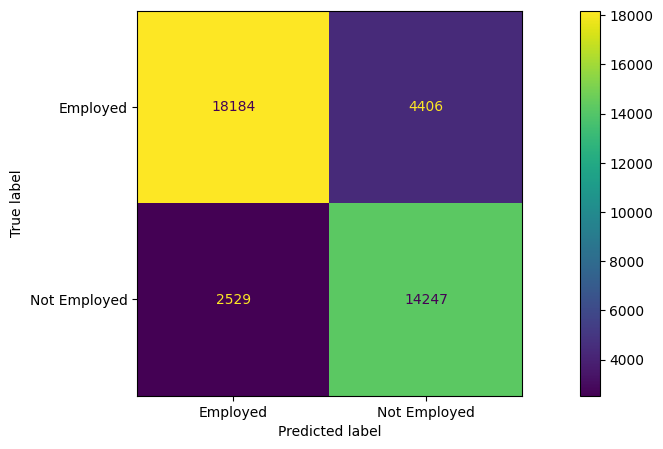

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Tuning for DecisionTreeClassifier is finished
####################  Folktables [LA]  ####################
Test model:  DecisionTreeClassifier
Test model parameters:
{'criterion': 'gini', 'max_depth': 10, 'max_features': 0.6}

              precision    recall  f1-score   support

       False      0.872     0.810     0.840     22590
        True      0.766     0.840     0.801     16776

    accuracy                          0.823     39366
   macro avg      0.819     0.825     0.821     39366
weighted avg      0.827     0.823     0.823     39366



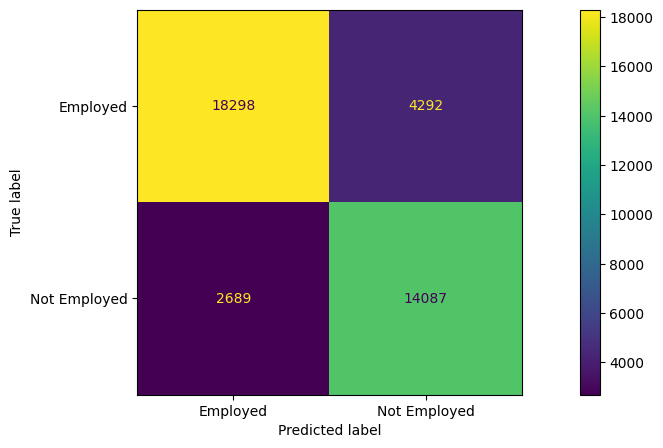

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Tuning for XGBClassifier is finished
####################  Folktables [LA]  ####################
Test model:  XGBClassifier
Test model parameters:
{'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 200,
 'objective': 'binary:logistic'}

              precision    recall  f1-score   support

       False      0.876     0.809     0.841     22590
        True      0.767     0.847     0.805     16776

    accuracy                          0.825     39366
   macro avg      0.822     0.828     0.823     39366
weighted avg      0.830     0.825     0.826     39366



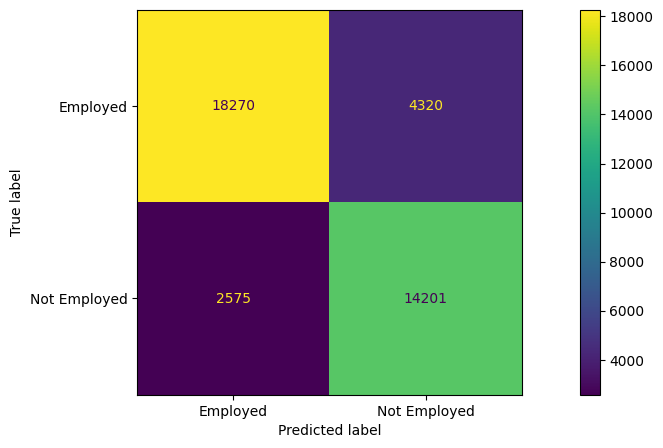

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,Folktables [LA],RandomForestClassifier,0.822053,0.823833,"{'bootstrap': True, 'max_depth': 10, 'max_feat..."
1,Folktables [LA],DecisionTreeClassifier,0.820612,0.822664,"{'criterion': 'gini', 'max_depth': 10, 'max_fe..."
2,Folktables [LA],XGBClassifier,0.822957,0.824849,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."


In [25]:
ML_results_df = test_ML_models(best_results_df, config_models, n_folds, samples_per_fold,
                               X_train, y_train, X_test, y_test, "Folktables [LA]", show_plots=True, debug_mode=True)
ML_results_df

In [26]:
for index, row in ML_results_df.iterrows():
  print(f'\n\nModel name: {row["Model_Name"]}')
  pprint(row['Model_Best_Params'])



Model name: RandomForestClassifier
{'bootstrap': True, 'max_depth': 10, 'max_features': 0.6, 'n_estimators': 30}


Model name: DecisionTreeClassifier
{'criterion': 'gini', 'max_depth': 10, 'max_features': 0.6}


Model name: XGBClassifier
{'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 200,
 'objective': 'binary:logistic'}
